In [1]:
import numpy as np
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as p9
from statsmodels.stats.multitest import fdrcorrection

from sklearn import preprocessing
from sklearn import metrics
import networkx as nx
import mantel

import pickle

# 1. Validate by index

In [2]:
def calc_strength_fraction_single(adj, set_S):
    W_i = adj[set_S, :][:, set_S].sum()
    W = adj[:4, :4].sum()+adj[4:8, 4:8].sum()+adj[8:12, 8:12].sum()+adj[12:, 12:].sum()
    return W_i/(adj.sum()-W)

def calc_strength_fraction(adj):
    W = adj[:4, :4].sum()+adj[4:8, 4:8].sum()+adj[8:12, 8:12].sum()+adj[12:, 12:].sum()
    return W/(adj.sum()-W)

def calc_conductance(nx_adj):
    cond = 0
    for set_S in [[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11], [12, 13, 14]]:
        cond += nx.algorithms.conductance(nx_adj, set_S, weight="weight")
    return -cond

def calc_normalized_cut(nx_adj):
    ncut = 0
    for set_S in [[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11], [12, 13, 14]]:
        ncut += nx.algorithms.normalized_cut_size(nx_adj, set_S, weight="weight")
    return -ncut

In [3]:
def significant_test_for_index(corr_mtx, n_perm=1000):
    # 0. data preparation
    corr_array = np.array(corr_mtx)
    np.fill_diagonal(corr_array, 0)
    corr_array_nx = nx.from_numpy_array(corr_array).to_undirected()

    # 1. calc index
    seg_index = np.array([calc_strength_fraction(corr_array), calc_conductance(corr_array_nx), calc_normalized_cut(corr_array_nx)])

    # 2. permutation
    perm_index = np.empty(shape=(n_perm, 3))
    for k in range(n_perm):
        tmp_idx = np.random.permutation(corr_array.shape[0])
        perm_corr = corr_array[tmp_idx, :][:, tmp_idx]
        perm_corr_g = nx.from_numpy_array(perm_corr).to_undirected()

        perm_index[k, 0] = calc_strength_fraction(perm_corr)
        perm_index[k, 1] = calc_conductance(perm_corr_g)
        perm_index[k, 2] = calc_normalized_cut(perm_corr_g)

    pval = ((perm_index>seg_index).sum(axis=0)+1)/n_perm

    # 3. multiple test correction
    _, fdr_bh = fdrcorrection(pval, alpha=0.05, method="indep", is_sorted=False)

    # 4. results
    seg_index[1:] = -seg_index[1:]
    perm_index[:, 1:] = -perm_index[:, 1:]

    return seg_index, perm_index, pval, fdr_bh

In [4]:
expr = pd.read_csv("../data/2.prodata/protomics_expr_processed.tsv", sep="\t", index_col=0)

In [5]:
corr_pr = expr.corr(method='pearson')
corr_sp = expr.corr(method='spearman')

upper_idx = np.triu(np.ones(shape=(15, 15)), 1).astype(bool)
r_pr_sp, p_pr_sp, _ = mantel.test(corr_pr.to_numpy()[upper_idx], corr_sp.to_numpy()[upper_idx], perms=10000, )
r_pr_sp, p_pr_sp

(0.9203666719963897, 0.0001)

In [56]:
corr_pr[corr_pr<0] = 0
pr_res = significant_test_for_index(corr_pr, n_perm=1000)
pr_res[-2], pr_res[-1]

(array([0.008, 0.009, 0.01 ]), array([0.01, 0.01, 0.01]))

In [105]:
sp_res = significant_test_for_index(corr_sp, n_perm=1000)
sp_res[-2], sp_res[-1]

(array([0.013, 0.01 , 0.011]), array([0.013, 0.013, 0.013]))

In [91]:
pr_dat_boxplot = pd.DataFrame(pr_res[1], columns=["Strength fraction", "Conductance", "Normalized cut"]).melt(var_name="Index", value_name="Value")
pr_dat_scatter = pd.DataFrame([pr_res[0], pr_res[-1]], index=["Value", "FDR"]).T
pr_dat_scatter["Index"] = ["Strength fraction", "Conductance", "Normalized cut"]
pr_dat_scatter["y"] = pr_dat_boxplot.groupby(pr_dat_boxplot["Index"]).quantile(0.99).loc[pr_dat_scatter["Index"]].values + 0.01
pr_dat_scatter


,Value,FDR,Index,y
0,0.255219,0.01,Strength fraction,0.264853
1,3.202402,0.01,Conductance,3.232311
2,4.270578,0.01,Normalized cut,4.306350


/mnt/d/workdir_for_Linux/software/Miniconda3/lib/python3.8/site-packages/plotnine/geoms/geom_point.py:61: UserWarning: You passed a edgecolor/edgecolors (['#db5f5780', '#db5f5780', '#db5f5780', '#db5f5780', '#db5f5780', '#db5f5780', '#db5f5780', '#db5f5780', '#db5f5780', '#db5f5780', '#db5f5780']) for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
/mnt/d/workdir_for_Linux/software/Miniconda3/lib/python3.8/site-packages/plotnine/geoms/geom_point.py:61: UserWarning: You passed a edgecolor/edgecolors (['#57db5f80', '#57db5f80', '#57db5f80', '#57db5f80', '#57db5f80', '#57db5f80', '#57db5f80', '#57db5f80', '#57db5f80', '#57db5f80', '#57db5f80', '#57db5f80']) for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
/mnt/d/workdir_for_Linux/software/Miniconda3/lib/python3.8/site-packages/plotnine/geoms/geom_point.py:61: UserWarning

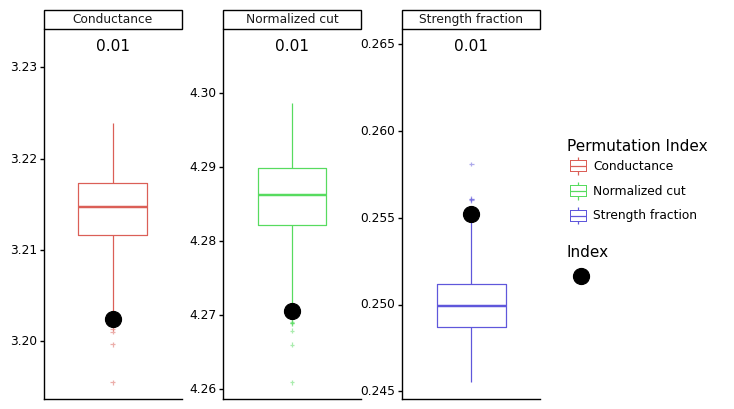

<ggplot: (8731649212910)>

In [110]:
pr_plot = ( p9.ggplot(p9.aes(x="Index", y="Value", color="Index", group="Index"), pr_dat_boxplot) 
  + p9.geom_boxplot(width=0.5, outlier_shape="+", outlier_alpha=0.5)
  + p9.geom_point(p9.aes(x="Index", y="Value", size=5), data=pr_dat_scatter, color="black", )
  + p9.geom_text(p9.aes(x="Index", y="y", label="FDR"), pr_dat_scatter, color="black")
  + p9.facet_wrap("~Index", nrow=1, ncol=3, scales="free")
  + p9.scale_color_discrete(name="Permutation Index")
  + p9.scale_size_continuous(name="Index", breaks=[5], labels=[" "])
  + p9.theme_classic()
  + p9.theme(subplots_adjust={'wspace': 0.30},
             axis_title=p9.element_blank(),
             axis_text_x=p9.element_blank(),
             axis_ticks_major_x=p9.element_blank(),
             axis_text=p9.element_text(color="black")
             
            )
)
p9.ggsave(pr_plot, "../res/pr_plot.pdf", units="in", width=6, height=4, verbose=False )
pr_plot

In [106]:
sp_dat_boxplot = pd.DataFrame(sp_res[1], columns=["Strength fraction", "Conductance", "Normalized cut"]).melt(var_name="Index", value_name="Value")
sp_dat_scatter = pd.DataFrame([sp_res[0], sp_res[-1]], index=["Value", "FDR"]).T
sp_dat_scatter["Index"] = ["Strength fraction", "Conductance", "Normalized cut"]
sp_dat_scatter["y"] = sp_dat_boxplot.groupby(sp_dat_boxplot["Index"]).quantile(0.99).loc[sp_dat_scatter["Index"]].values + 0.01
sp_dat_scatter

,Value,FDR,Index,y
0,0.276436,0.013,Strength fraction,0.287443
1,3.147877,0.013,Conductance,3.271582
2,4.201836,0.013,Normalized cut,4.358489


/mnt/d/workdir_for_Linux/software/Miniconda3/lib/python3.8/site-packages/plotnine/geoms/geom_point.py:61: UserWarning: You passed a edgecolor/edgecolors (['#db5f5780', '#db5f5780', '#db5f5780', '#db5f5780', '#db5f5780', '#db5f5780', '#db5f5780', '#db5f5780', '#db5f5780', '#db5f5780']) for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
/mnt/d/workdir_for_Linux/software/Miniconda3/lib/python3.8/site-packages/plotnine/geoms/geom_point.py:61: UserWarning: You passed a edgecolor/edgecolors (['#57db5f80', '#57db5f80', '#57db5f80', '#57db5f80', '#57db5f80', '#57db5f80', '#57db5f80', '#57db5f80', '#57db5f80']) for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
/mnt/d/workdir_for_Linux/software/Miniconda3/lib/python3.8/site-packages/plotnine/geoms/geom_point.py:61: UserWarning: You passed a edgecolor/edgecolors (['#5f57db80', '

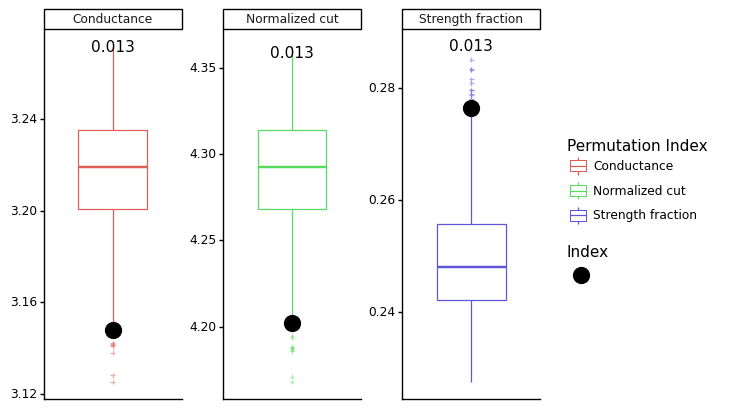

<ggplot: (8731649433543)>

In [111]:
sp_plot = ( p9.ggplot(p9.aes(x="Index", y="Value", color="Index", group="Index"), sp_dat_boxplot) 
  + p9.geom_boxplot(width=0.5, outlier_shape="+", outlier_alpha=0.5)
  + p9.geom_point(p9.aes(x="Index", y="Value", size=5), data=sp_dat_scatter, color="black", )
  + p9.geom_text(p9.aes(x="Index", y="y", label="FDR"), sp_dat_scatter, color="black")
  + p9.facet_wrap("~Index", nrow=1, ncol=3, scales="free")
  + p9.scale_color_discrete(name="Permutation Index")
  + p9.scale_size_continuous(name="Index", breaks=[5], labels=[" "])
  + p9.theme_classic()
  + p9.theme(subplots_adjust={'wspace': 0.30},
             axis_title=p9.element_blank(),
             axis_text_x=p9.element_blank(),
             axis_ticks_major_x=p9.element_blank(),
             axis_text=p9.element_text(color="black")
             
            )
)
p9.ggsave(sp_plot, "../res/sp_plot.pdf", units="in", width=6, height=4, verbose=False )
sp_plot

# Validate by unsupervised clustering indicator
* silhouette
* calinski_harabasz
* davies_bouldin

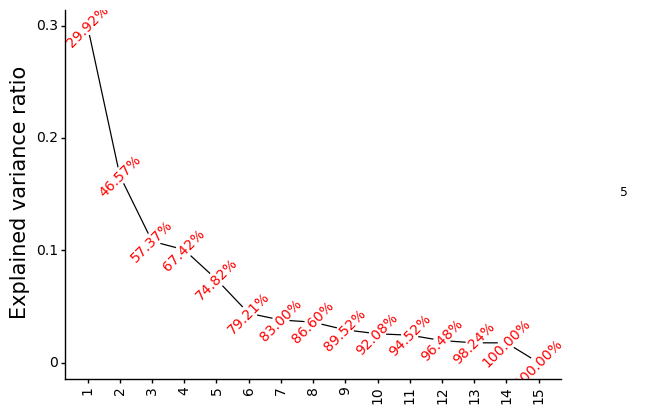

<ggplot: (8731649955738)>

In [114]:
expr_scale, pca_obj, tsne_obj, umap_obj = pickle.load(open("../res/0.preprocessing_DR.pkl", 'rb'))
cum_var_ratio = [f"{i:.2%}" for i in np.cumsum(pca_obj.explained_variance_ratio_)]

( p9.ggplot()
  + p9.geom_line(p9.aes(x=range(1, 16), y=pca_obj.explained_variance_ratio_))
  + p9.geom_point(p9.aes(x=range(1, 16), y=pca_obj.explained_variance_ratio_, size=5), color="white")
  + p9.geom_text(p9.aes(x=range(1, 16), y=pca_obj.explained_variance_ratio_, label=cum_var_ratio, angle=45), color="red", size=10)
  + p9.ylab("Explained variance ratio")
  + p9.scale_x_continuous(breaks=range(1, 16), labels=range(1, 16))
  + p9.theme_classic()
  + p9.theme(axis_title=p9.element_text(color="black", size=15),
             axis_text=p9.element_text(color="black", size=10),
             axis_text_x=p9.element_text(angle=90),
             legend_title=p9.element_blank())
)

In [218]:
group = ("INS "+pd.Series(expr.columns).str.split('-', expand=True)[0]).to_numpy()
n_perm = 1000

score = np.empty(shape=(3*15))
score_perm = np.empty(shape=(n_perm, 3*15))
for n in range(15):
    feat_mtx = pca_obj.transform(expr_scale)[:, :n+1]
    if n == 0:
        score[n] = metrics.silhouette_score(feat_mtx, group, metric="euclidean")
    else:
        score[n] = metrics.silhouette_score(feat_mtx, group, metric="correlation")
    score[n+15] = metrics.calinski_harabasz_score(feat_mtx, group)
    score[n+30] = -metrics.davies_bouldin_score(feat_mtx, group)

    for k in range(n_perm):
        tmp_idx = np.random.permutation(15)
        feat_mtx_perm = feat_mtx[tmp_idx, :]
        if n == 0:
            score[n] = metrics.silhouette_score(feat_mtx, group, metric="euclidean")
        else:
            score[n] = metrics.silhouette_score(feat_mtx, group, metric="correlation")
        score_perm[k, n+15] = metrics.calinski_harabasz_score(feat_mtx_perm, group)
        score_perm[k, n+30] = -metrics.davies_bouldin_score(feat_mtx_perm, group)

In [219]:
 pval = ( (score_perm > score).sum(axis=0)+1)/(n_perm+1)

In [220]:
is_accept, padj = fdrcorrection(pval, alpha=0.05, method="indep", is_sorted=False)
padj

array([1.        , 0.03146853, 0.01498501, 0.02311974, 0.01498501,
       0.0128443 , 0.0128443 , 0.0128443 , 0.0128443 , 0.01348651,
       0.0128443 , 0.0128443 , 0.01348651, 0.01348651, 0.0128443 ,
       0.01860209, 0.01983311, 0.02720963, 0.01831502, 0.01498501,
       0.01498501, 0.01498501, 0.01383232, 0.01498501, 0.01831502,
       0.01383232, 0.01498501, 0.01498501, 0.01831502, 0.01383232,
       0.26973027, 0.14427433, 0.1019712 , 0.11345797, 0.01907184,
       0.01831502, 0.01885212, 0.01831502, 0.02372627, 0.02673003,
       0.01885212, 0.01831502, 0.01907184, 0.02766464, 0.01860209])

In [236]:
diff_score = (score - np.median(score_perm, axis=0))
diff_score

array([-0.08066366,  0.2       ,  0.3207339 ,  0.22701114,  0.27680798,
        0.28995837,  0.28497834,  0.25419072,  0.22214403,  0.21521808,
        0.22083452,  0.2160134 ,  0.19372757,  0.17543166,  0.17355294,
        3.83219855,  2.05640802,  1.54079528,  1.42444849,  1.41363307,
        1.28433879,  1.24967419,  1.13441408,  1.04813417,  0.9754094 ,
        0.97404218,  0.93602882,  0.87922453,  0.83491361,  0.83587493,
        3.50073815,  1.6108778 ,  1.25385825,  0.97819456,  1.2308344 ,
        1.1186759 ,  1.02167732,  0.90219191,  0.79075247,  0.73605743,
        0.73811111,  0.70796212,  0.6428657 ,  0.59034066,  0.6072465 ])

In [237]:
coeff_dat_line = pd.DataFrame( [score, diff_score, np.array(list(range(1, 16)) * 3), np.repeat(["Silhouette", "Calinski Harabasz", "Davies Bouldin"], 15), padj], index=["Score", "Ratio", "PC", "Index", "FDR"]).T
coeff_dat_line["Ratio"] = coeff_dat_line["Ratio"].astype(float)
coeff_dat_line["Score"] = coeff_dat_line["Score"].astype(float)
coeff_dat_line["FDR"] = -np.log10(coeff_dat_line["FDR"].astype(float))
coeff_dat_point = coeff_dat_line.loc[is_accept, :]


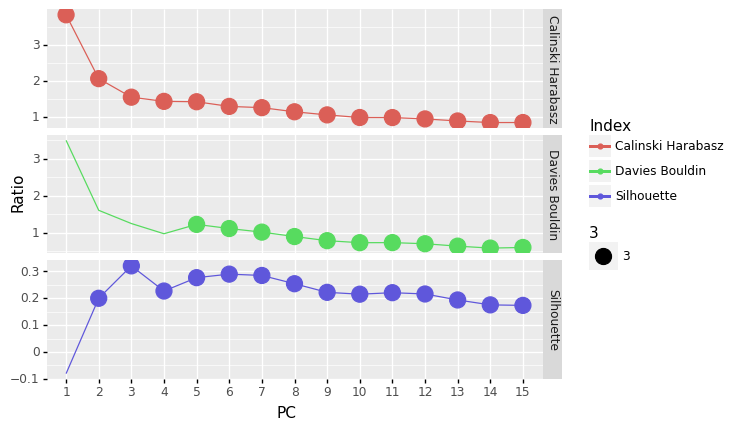

<ggplot: (8731639231166)>

In [238]:
coeff_plot = ( p9.ggplot(p9.aes(x="PC", y="Ratio", group="Index", color="Index"), coeff_dat_line)
               + p9.geom_line()
               + p9.geom_point(p9.aes(x="PC", y="Ratio", color="Index", size=3), coeff_dat_point)
               + p9.facet_grid("Index~", scales="free_y")
)

coeff_plot

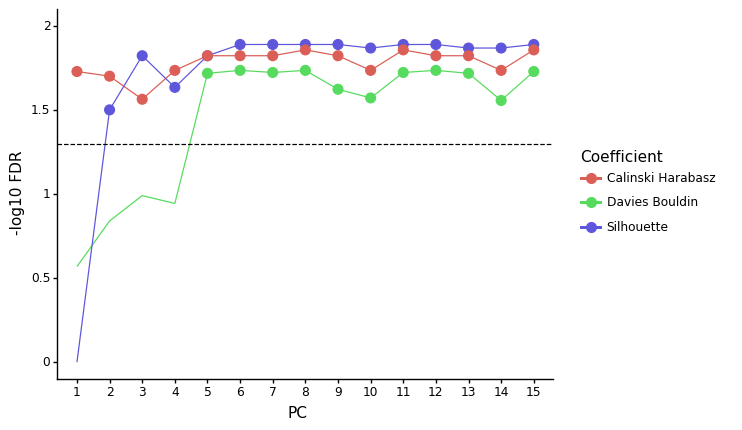

<ggplot: (8731649823422)>

In [262]:
size=0.01
coeff_plot = ( p9.ggplot(p9.aes(x="PC", y="FDR", group="Index", color="Index"), coeff_dat_line)
               + p9.geom_line()
               + p9.geom_hline(yintercept=-np.log10(0.05), linetype="dashed")
               + p9.ylim(0, 2) + p9.ylab("-log10 FDR")
               + p9.geom_point(p9.aes(x="PC", y="FDR", color="Index"), coeff_dat_point, size=3.5)
               + p9.theme_classic()
               + p9.theme(axis_text=p9.element_text(color="black"))
               + p9.scale_color_discrete(name="Coefficient")
               + p9.scale_size_continuous(name="FDR < 0.05", breaks=[size], labels=[" "])
)
p9.ggsave(coeff_plot, "../res/coeff_plot.pdf", units="in", width=6, height=4, verbose=False)
coeff_plot

In [260]:
pval

array([1.00000000e+00, 2.79720280e-02, 6.99300699e-03, 1.79820180e-02,
       5.99400599e-03, 1.99800200e-03, 9.99000999e-04, 1.99800200e-03,
       1.99800200e-03, 2.99700300e-03, 9.99000999e-04, 9.99000999e-04,
       2.99700300e-03, 2.99700300e-03, 1.99800200e-03, 1.19880120e-02,
       1.49850150e-02, 2.29770230e-02, 1.09890110e-02, 6.99300699e-03,
       6.99300699e-03, 5.99400599e-03, 3.99600400e-03, 6.99300699e-03,
       9.99000999e-03, 3.99600400e-03, 4.99500500e-03, 6.99300699e-03,
       8.99100899e-03, 3.99600400e-03, 2.63736264e-01, 1.37862138e-01,
       9.29070929e-02, 1.05894106e-01, 1.39860140e-02, 9.99000999e-03,
       1.29870130e-02, 1.09890110e-02, 1.89810190e-02, 2.19780220e-02,
       1.29870130e-02, 1.09890110e-02, 1.39860140e-02, 2.39760240e-02,
       1.19880120e-02])